# Lab Report 3

## Group 3
## Caroline Kuntz 940915-1462
## Niklas Landsberg 940421-T857

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [2]:
#Assumptions
risk_free_rate=0.002

In [3]:
#Functions used for Global Minimum Variance portfolio

#1. Define portfolio return
def portfolio_return(weights,returns):
    return weights.T @ returns

#2. Define portfolio variance
def portfolio_risk(weights, cov_matrix):
    return(weights.T @ cov_matrix @ weights)**0.5


#3. Define minimimum risk
def minimize_risk(target_return, Expected_Return, cov):

    n=Expected_Return.shape[0]

    initial_guess=np.repeat(1/n,n)
    
    bounds=((0,1),)*n
    
    #Constraints
    return_is_target={
        'type':'eq',
        'args':(Expected_Return,),
        'fun':lambda weights,
        Expected_Return: target_return-portfolio_return(weights, Expected_Return)
    }
    
    weights_sum_to_1={
        'type':'eq',
        'fun':lambda weights:np.sum(weights)-1
    }
    
    results=minimize(portfolio_risk, 
                     initial_guess,
                     args=(cov,),
                     method="SLSQP", 
                     constraints=(return_is_target,weights_sum_to_1),
                     bounds=bounds
                    )
    return results.x

#4. Define Maximum Sharpe Ratio
def maximum_sharpe_ratio(risk_free_rate, Expected_Return, cov):
    
    n=Expected_Return.shape[0]
    
    initial_guess=np.repeat(1/n,n)
    
    bounds=((0,1),)*n
    
    weights_sum_to_1={
        'type':'eq',
        'fun':lambda weights:np.sum(weights)-1
    }
    
    def neg_sharpe_ratio(weights, risk_free_rate, Expected_Return,cov):
        
        sharpe_ratio=(portfolio_return(weights, Expected_Return)-risk_free_rate)/portfolio_risk(weights, cov)
        return -1*sharpe_ratio
    
    results=minimize(neg_sharpe_ratio, 
                     initial_guess,
                     args=(risk_free_rate, Expected_Return, cov,), 
                     method="SLSQP",
                     constraints=(weights_sum_to_1), 
                     bounds=bounds)
    return results.x

#5. Draw the efficient frontier

def optimal_weights(n_points, Expected_Return,cov):
    
    target_returns=np.linspace(Expected_Return.min(), Expected_Return.max(), n_points)
    
    weights=[minimize_risk(target_return, Expected_Return, cov) for target_return in target_returns]
    return weights

def plot_efficient_frontier(n_points,Expected_Return,cov):
    
    weights= optimal_weights(n_points, Expected_Return,cov)
    
    Returns=[portfolio_return(w,Expected_Return) for w in weights]
    
    Risk=[portfolio_risk(w,cov) for w in weights]
    
    efficient_frontier=pd.DataFrame({"Return":Returns, "Risk":Risk})
    return efficient_frontier.plot.scatter(x="Risk",y="Return")

#6. Global mininmum variance portfolio
def gmv(cov):
    n=cov.shape[0]
    return maximum_sharpe_ratio(0, np.repeat(1,n), cov)

#7. Tracking_Error

def tracking_error(return_manager,return_muster_portfolio):
    return np.sqrt(((return_manager-return_muster_portfolio)**2).sum())

#8. 
def portfolio_tracking_error(weights,reference_return,asset_returns):
    return tracking_error(reference_return,(weights*asset_returns).sum(axis=1))

#9. Sharpe Style Analysis
def style_analysis(return_of_the_manager, return_of_the_different_factors):
    
    n=return_of_the_different_factors.shape[1]
    
    init_guess=np.repeat(1/n,n)
    
    bounds=((0,1),)*n
    
    weights_sum_to_1={
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    
    solution=minimize(portfolio_tracking_error,
                     init_guess,
                     args=(return_of_the_manager, return_of_the_different_factors,),
                     method='SLSQP',
                     constraints=(weights_sum_to_1,),
                     bounds=bounds)
    weights=pd.Series(solution.x,index=return_of_the_different_factors.columns)
    return weights

In [4]:
#### Clean the data
data_return= pd.read_csv('industry_portfolios_30.csv',index_col=0)

data_return= data_return.replace(" ","")

data_return.dropna()

data_return.index=pd.to_datetime(data_return.index, format="%Y%m")

data_return.index=data_return.index.to_period('M')

data_return.columns=data_return.columns.str.strip()

data_return=data_return/100

data_return.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2019-08,0.0108,0.0619,-0.1104,-0.0588,-0.0459,0.0158,-0.0498,-0.0045,-0.0566,-0.0547,...,0.0043,-0.0213,-0.0359,-0.0296,-0.0687,-0.0234,-0.0012,0.0134,-0.0469,-0.0213
2019-09,0.0050,0.0162,0.0195,-0.0467,0.0139,0.0175,0.0914,-0.0054,0.0560,0.0741,...,0.0130,-0.0106,0.0436,0.0174,0.0054,0.0536,0.0096,-0.0249,0.0258,0.0219
2019-10,-0.0166,-0.0104,0.0810,0.0584,0.0135,-0.0072,-0.0218,0.0447,-0.0095,0.1062,...,0.0223,0.0188,0.0537,0.0000,0.0137,0.0245,0.0165,-0.0427,0.0329,0.0189
2019-11,0.0199,-0.0059,0.0552,0.0615,-0.0099,-0.0128,0.0467,0.0530,0.0382,-0.0224,...,0.0175,0.0503,0.0478,0.0312,0.0275,0.0441,0.0206,0.0282,0.0568,0.0424
2019-12,0.0358,0.0138,0.0322,0.0397,0.0323,0.0263,0.0768,0.0333,0.0135,-0.0342,...,0.0124,0.0179,0.0624,0.0217,-0.0024,0.0239,0.0121,0.0259,0.0259,0.0205


## Choose three portfolios and find the tangency portfolios for those assets

In [5]:
Assets_1=['Food','Games','Hlth']
portfolio_1=data_return[Assets_1]
expected_return_1 = portfolio_1.mean()
cov_1= portfolio_1.cov()

In [6]:
expected_return_1

Food     0.009677
Games    0.011446
Hlth     0.010848
dtype: float64

In [7]:
cov_1

,Food,Games,Hlth
Food,0.002227,0.002953,0.002023
Games,0.002953,0.007921,0.003334
Hlth,0.002023,0.003334,0.003074


In [8]:
Assets_2=['Clths','Chems','Fin',]
portfolio_2=data_return[Assets_2]
expected_return_2 = portfolio_2.mean()
cov_2= portfolio_2.cov()

In [9]:
expected_return_2

Clths    0.009535
Chems    0.010465
Fin      0.010284
dtype: float64

In [10]:
cov_2

,Clths,Chems,Fin
Clths,0.003710,0.002515,0.002727
Chems,0.002515,0.003948,0.003386
Fin,0.002727,0.003386,0.004570


In [11]:
Assets_3=['Books','Telcm','Rtail']
portfolio_3=data_return[Assets_3]
expected_return_3 = portfolio_3.mean()
cov_3= portfolio_3.cov()

In [12]:
expected_return_3

Books    0.008943
Telcm    0.008607
Rtail    0.010428
dtype: float64

In [13]:
cov_3

,Books,Telcm,Rtail
Books,0.005103,0.002042,0.003240
Telcm,0.002042,0.002094,0.001817
Rtail,0.003240,0.001817,0.003541


In [14]:
weight_max_1=maximum_sharpe_ratio(risk_free_rate,expected_return_1,cov_1)
Return_Sharpe_1=portfolio_return(weight_max_1,expected_return_1.values)
Risk_Sharpe_1=portfolio_risk(weight_max_1,cov_1)

In [15]:
weight_max_1

array([0.57958469, 0.        , 0.42041531])

In [16]:
Return_Sharpe_1

0.010169161842111842

In [17]:
Risk_Sharpe_1

0.0477212550513593

In [18]:
weight_max_2=maximum_sharpe_ratio(risk_free_rate,expected_return_2,cov_2)
Return_Sharpe_2=portfolio_return(weight_max_2,expected_return_2.values)
Risk_Sharpe_2=portfolio_risk(weight_max_2,cov_2)

In [19]:
weight_max_2

array([0.36971129, 0.51136253, 0.11892619])

In [20]:
Return_Sharpe_2

0.01009957348061519

In [21]:
Risk_Sharpe_2

0.0566294690470964

In [22]:
weight_max_3=maximum_sharpe_ratio(risk_free_rate,expected_return_3,cov_3)
Return_Sharpe_3=portfolio_return(weight_max_3,expected_return_3.values)
Risk_Sharpe_3=portfolio_risk(weight_max_3,cov_3)

In [23]:
weight_max_3

array([8.21265314e-17, 5.89718247e-01, 4.10281753e-01])

In [24]:
Return_Sharpe_3

0.009354294495377037

In [25]:
Risk_Sharpe_3

0.046942143124458796

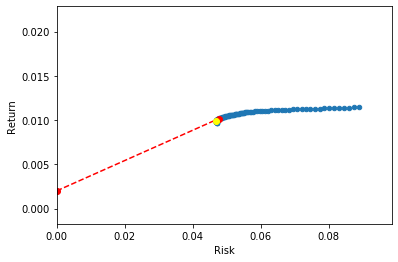

In [26]:
ax=plot_efficient_frontier(100,expected_return_1.values,cov_1)
ax.set_xlim(left=0)

#Tangency Portfolio 1
cml_x=[0,Risk_Sharpe_1]
cml_y=[risk_free_rate, Return_Sharpe_1]

ax.plot(cml_x,cml_y,color="red",marker="o",linestyle="dashed")

#GMV 1
weight_gmv_1=gmv(cov_1)
Return_gmv_1=portfolio_return(weight_gmv_1,expected_return_1.values)
Risk_gmv_1=portfolio_risk(weight_gmv_1,cov_1)
                                
ax.plot([Risk_gmv_1],[Return_gmv_1],color="yellow", marker="o",linestyle="dashed")



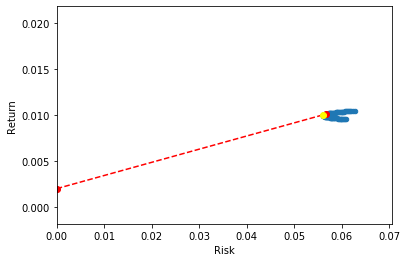

In [27]:
ax=plot_efficient_frontier(100,expected_return_2.values,cov_2)
ax.set_xlim(left=0)

#Tangency Portfolio 2
cml_x=[0,Risk_Sharpe_2]
cml_y=[risk_free_rate, Return_Sharpe_2]

ax.plot(cml_x,cml_y,color="red",marker="o",linestyle="dashed")

#GMV 2
weight_gmv_2=gmv(cov_2)
Return_gmv_2=portfolio_return(weight_gmv_2,expected_return_2.values)
Risk_gmv_2=portfolio_risk(weight_gmv_2,cov_2)
                                
ax.plot([Risk_gmv_2],[Return_gmv_2],color="yellow", marker="o",linestyle="dashed")


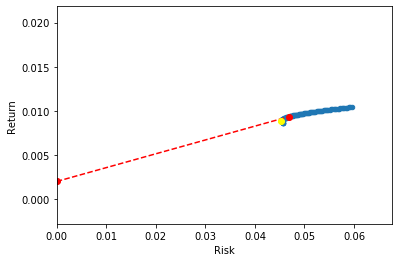

In [28]:
ax=plot_efficient_frontier(100,expected_return_3.values,cov_3)
ax.set_xlim(left=0)

#Tangency Portfolio 3
cml_x=[0,Risk_Sharpe_3]
cml_y=[risk_free_rate, Return_Sharpe_3]

ax.plot(cml_x,cml_y,color="red",marker="o", linestyle="dashed")

#GMV 3
weight_gmv_3=gmv(cov_3)
Return_gmv_3=portfolio_return(weight_gmv_3,expected_return_3.values)
Risk_gmv_3=portfolio_risk(weight_gmv_3,cov_3)
                                
ax.plot([Risk_gmv_3],[Return_gmv_3],color="yellow", marker="o",linestyle="dashed")

We can see that the tangency portfolio is above the gmv which is to expect and is a proof that things are correct

## Change the expected return of the three assets slightly, compute the efficient portfolios again and see if the optimal weights change

In [29]:
noise=np.random.normal(scale=0.15/(12*0.5))

In [30]:
expected_return_1_noise = portfolio_1.mean()+noise

In [31]:
expected_return_2_noise = portfolio_2.mean()+noise

In [32]:
expected_return_3_noise = portfolio_3.mean()+noise

In [33]:
weight_max_1=maximum_sharpe_ratio(risk_free_rate,expected_return_1,cov_1)
weight_max_1

array([0.57958469, 0.        , 0.42041531])

In [34]:
weight_max_1_noise=maximum_sharpe_ratio(risk_free_rate,expected_return_1_noise,cov_1)
weight_max_1_noise

array([7.21111007e-17, 1.00000000e+00, 0.00000000e+00])

In [35]:
weight_1_change = ((weight_max_1-weight_max_1_noise)**2)**0.5
weight_1_change

array([0.57958469, 1.        , 0.42041531])

In [36]:
weight_1_change=pd.DataFrame({"weights": weight_1_change})

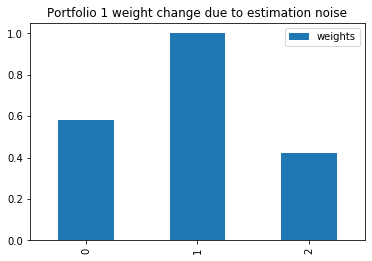

In [37]:
weight_1_change.plot.bar(title="Portfolio 1 weight change due to estimation noise")

In [38]:
weight_max_2=maximum_sharpe_ratio(risk_free_rate,expected_return_2,cov_2)
weight_max_2

array([0.36971129, 0.51136253, 0.11892619])

In [39]:
weight_max_2_noise=maximum_sharpe_ratio(risk_free_rate,expected_return_2_noise,cov_2)
weight_max_2_noise

array([2.40370336e-16, 0.00000000e+00, 1.00000000e+00])

In [40]:
weight_2_change = ((weight_max_2-weight_max_2_noise)**2)**0.5
weight_2_change

array([0.36971129, 0.51136253, 0.88107381])

In [41]:
weight_2_change=pd.DataFrame({"weights": weight_2_change})

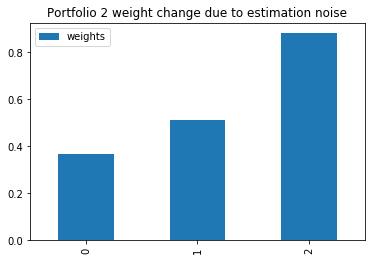

In [42]:
weight_2_change.plot.bar(title="Portfolio 2 weight change due to estimation noise")

In [43]:
weight_max_3=maximum_sharpe_ratio(risk_free_rate,expected_return_3,cov_3)
weight_max_3

array([8.21265314e-17, 5.89718247e-01, 4.10281753e-01])

In [44]:
weight_max_3_noise=maximum_sharpe_ratio(risk_free_rate,expected_return_3_noise,cov_3)
weight_max_3_noise

array([1.00000000e+00, 0.00000000e+00, 1.52655666e-16])

In [45]:
weight_3_change = ((weight_max_3-weight_max_3_noise)**2)**0.5
weight_3_change

array([1.        , 0.58971825, 0.41028175])

In [46]:
weight_3_change=pd.DataFrame({"weights": weight_3_change})

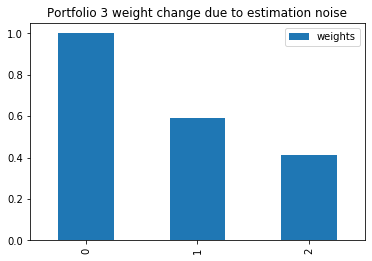

In [47]:
weight_3_change.plot.bar(title="Portfolio 3 weight change due to estimation noise")

We can clearly see that the weights changed dramatically with a change in the expected return. The changes can lead to investment or disinvestment which is quite heavy as an outcome. By looking at the absolute change of weights - we are interested if the weights changed in either directions and we observe massive swings

## 4. Choose a mutual find in yahoo finance and download its historical returns

In [48]:
#### Clean the data ####

#Morgan Stanley Institutional Fund, Inc. Global Advantage Portfolio 

fund_return=pd.read_csv('MIGPX.csv',index_col=0)

fund_return=fund_return.replace(" ","")

fund_return.dropna()

fund_return.index=pd.to_datetime(fund_return.index, format="%Y-%m-%d")

fund_return.index=fund_return.index.to_period('M')

fund_return.columns=fund_return.columns.str.strip()

fund_return=fund_return/100

fund_return=fund_return['Adj Close']

fund_return=fund_return['2010':'2018']

fund_return

Date
2010-12    0.061359
2011-01    0.060991
2011-02    0.062769
2011-03    0.063689
2011-04    0.067857
             ...   
2018-08    0.157732
2018-09    0.157254
2018-10    0.141023
2018-11    0.140736
2018-12    0.134039
Freq: M, Name: Adj Close, Length: 97, dtype: float64

## 5. Do Sharpe-style analysis on this fund using three factors (market, size, value)

In [49]:
# Factor uploading

fff=pd.read_csv('fff_factors.csv',index_col=0)
fff.index=pd.to_datetime(fff.index, format="%Y%m")
fff=fff/100
fff.index=fff.index.to_period('M')
fff.tail()

,Mkt-RF,SMB,HML,RF
2018-08,0.0344,0.0123,-0.0412,0.0016
2018-09,0.0006,-0.0237,-0.0134,0.0015
2018-10,-0.0768,-0.0468,0.0341,0.0019
2018-11,0.0169,-0.0074,0.0020,0.0018
2018-12,-0.0955,-0.0261,-0.0151,0.0019


In [50]:
factors=fff.loc["2003":"2018",['Mkt-RF','SMB','HML']]
factors["constant"]=1

In [51]:
factors

,Mkt-RF,SMB,HML,constant
2003-01,-0.0257,0.0139,-0.0093,1
2003-02,-0.0188,-0.0034,-0.0146,1
2003-03,0.0109,0.0089,-0.0209,1
2003-04,0.0822,0.0057,0.0103,1
2003-05,0.0605,0.0470,-0.0030,1
...,...,...,...,...
2018-08,0.0344,0.0123,-0.0412,1
2018-09,0.0006,-0.0237,-0.0134,1
2018-10,-0.0768,-0.0468,0.0341,1
2018-11,0.0169,-0.0074,0.0020,1


In [52]:
weights = style_analysis(fund_return,factors)

In [53]:
weights

Mkt-RF      0.064457
SMB         0.489089
HML         0.347908
constant    0.098546
dtype: float64

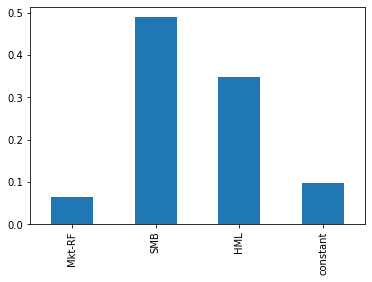

In [54]:
weights.plot.bar()

In [55]:
factor_exposure = dict(weights)

In [56]:
for factor in factor_exposure:
    print(f'The exposure of the fund to the factor {factor} is {round(factor_exposure.get(factor),6)}')

The exposure of the fund to the factor Mkt-RF is 0.064457
The exposure of the fund to the factor SMB is 0.489089
The exposure of the fund to the factor HML is 0.347908
The exposure of the fund to the factor constant is 0.098546
